# Battery Pack Predictive Maintenance AI Dataset Analysis and Modeling

이 노트북은 배터리팩 용접 품질 예측을 위한 데이터 분석과 머신러닝 모델링을 수행합니다.
- **목표**: OK(정상)와 NG(불량) 분류
- **데이터**: 배터리 용접 공정 센서 데이터

## 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

# 시각화 설정
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load and Explore the Battery Dataset

In [2]:
# 데이터 로드 함수
def load_data(file_path, label):
    """CSV 파일을 로드하고 라벨을 추가합니다"""
    df = pd.read_csv(file_path)
    df['Label'] = label
    return df

# 경로 설정
base_path = r'c:\Users\User\Desktop\battery\data\raw_data'

# 훈련 데이터
train_df = load_data(f'{base_path}\\train\\Training_Data.csv', 'OK')

# 테스트 데이터 - OK
test_ok_df = load_data(f'{base_path}\\test\\WeldingTest_01_OK.csv', 'OK')
test_ok_df2 = load_data(f'{base_path}\\test\\WeldingTest_02_OK.csv', 'OK')

# 테스트 데이터 - NG
test_ng_df = load_data(f'{base_path}\\test\\WeldingTest_03_NG.csv', 'NG')
test_ng_df2 = load_data(f'{base_path}\\test\\WeldingTest_04_NG.csv', 'NG')

# 데이터 통합
all_data = pd.concat([train_df, test_ok_df, test_ok_df2, test_ng_df, test_ng_df2], ignore_index=True)

print("Dataset loaded successfully!")
print(f"Total records: {len(all_data)}")
print(f"\nDataset shape: {all_data.shape}")
print(f"\nFirst rows:\n{all_data.head()}")
print(f"\nData types:\n{all_data.dtypes}")
print(f"\nLabel distribution:\n{all_data['Label'].value_counts()}")

Dataset loaded successfully!
Total records: 140985

Dataset shape: (140985, 10)

First rows:
    PageNo   Speed   Length   RealPower   SetFrequency   SetDuty   SetPower  \
0        1     250    241.1        1688           1000       100         82   
1        2     250    241.2        1713           1000       100         83   
2        3     250    241.1        1695           1000       100         82   
3        4     250    241.2        1717           1000       100         83   
4        5     250    241.1        1698           1000       100         82   

    GateOnTime               WorkingTime Label  
0         1154   2022-01-08 10:11:45.181    OK  
1         1670   2022-01-08 10:11:48.487    OK  
2         1153   2022-01-08 10:11:51.245    OK  
3         1670   2022-01-08 10:11:54.493    OK  
4         1154   2022-01-08 10:11:57.269    OK  

Data types:
 PageNo            int64
 Speed             int64
 Length          float64
 RealPower         int64
 SetFrequency      int64


## 3. Data Preprocessing and Cleaning

In [3]:
# 데이터 전처리
print("=== Data Preprocessing ===")
print(f"Missing values before:\n{all_data.isnull().sum()}")

# 공백 문자 제거
all_data.columns = all_data.columns.str.strip()

# 중복 제거
print(f"\nDuplicate rows before: {all_data.duplicated().sum()}")
all_data = all_data.drop_duplicates()
print(f"Duplicate rows after: {all_data.duplicated().sum()}")

# 데이터 타입 변환
print("\n=== Data Type Conversion ===")
numeric_cols = ['PageNo', 'Speed', 'Length', 'RealPower', 'SetFrequency', 'SetDuty', 'SetPower', 'GateOnTime']
for col in numeric_cols:
    all_data[col] = pd.to_numeric(all_data[col], errors='coerce')

# WorkingTime을 datetime으로 변환
all_data['WorkingTime'] = pd.to_datetime(all_data['WorkingTime'], errors='coerce')

print(f"Missing values after conversion:\n{all_data.isnull().sum()}")

# 결측값 처리 (있을 경우 제거)
all_data = all_data.dropna()
print(f"\nFinal dataset shape: {all_data.shape}")
print(f"Label distribution after cleaning:\n{all_data['Label'].value_counts()}")

=== Data Preprocessing ===
Missing values before:
 PageNo          0
 Speed           0
 Length          0
 RealPower       0
 SetFrequency    0
 SetDuty         0
 SetPower        0
 GateOnTime      0
 WorkingTime     0
Label            0
dtype: int64

Duplicate rows before: 0
Duplicate rows after: 0

=== Data Type Conversion ===
Missing values after conversion:
PageNo          0
Speed           0
Length          0
RealPower       0
SetFrequency    0
SetDuty         0
SetPower        0
GateOnTime      0
WorkingTime     0
Label           0
dtype: int64

Final dataset shape: (140985, 10)
Label distribution after cleaning:
Label
OK    139581
NG      1404
Name: count, dtype: int64


## 4. Exploratory Data Analysis (EDA)

In [4]:
# 기본 통계
print("=== Basic Statistics ===")
print(all_data.describe())

# 라벨별 통계
print("\n=== Statistics by Label ===")
print(all_data.groupby('Label').describe())

=== Basic Statistics ===
              PageNo          Speed         Length      RealPower  \
count  140985.000000  140985.000000  140985.000000  140985.000000   
mean       20.000000     165.027556     155.546872    1308.904054   
min         1.000000      30.000000      19.400000       0.000000   
25%        10.000000      30.000000      19.400000     688.000000   
50%        20.000000     250.000000     241.100000    1687.000000   
75%        30.000000     250.000000     241.200000    1703.000000   
max        39.000000     250.000000     241.200000    1733.000000   
std        11.254669     106.979932     107.809263     493.999086   

       SetFrequency   SetDuty       SetPower     GateOnTime  \
count      140985.0  140985.0  140985.000000  140985.000000   
mean         1000.0     100.0      65.383977    1118.022350   
min          1000.0     100.0      35.000000     650.000000   
25%          1000.0     100.0      38.000000     650.000000   
50%          1000.0     100.0      82.

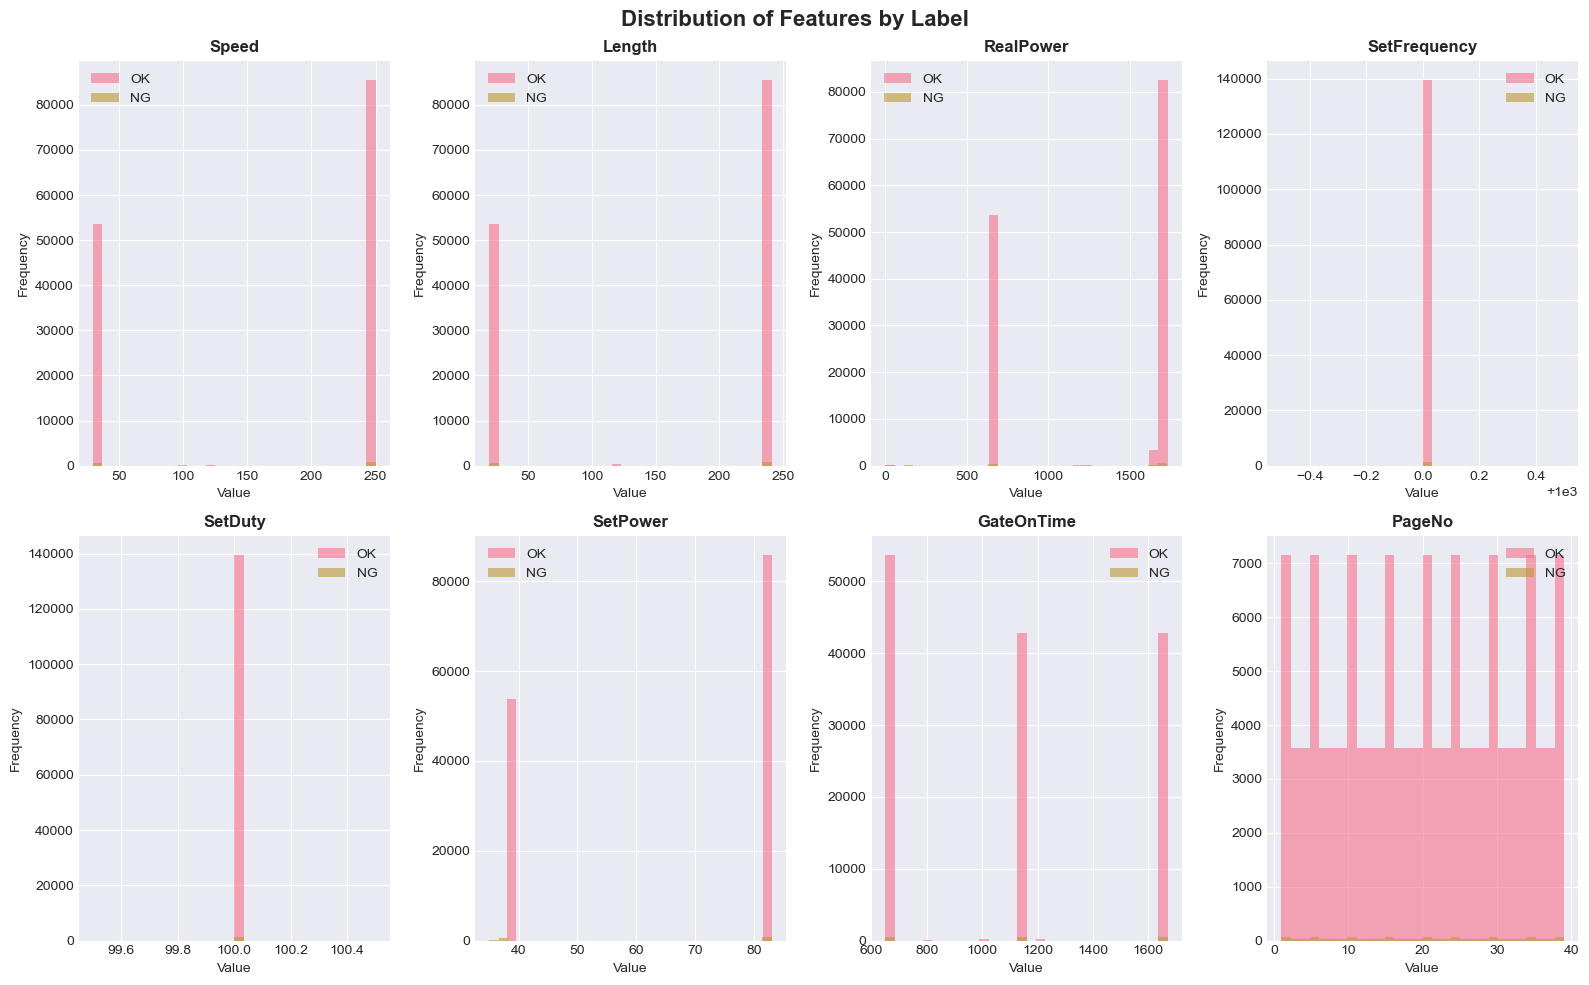

Distribution analysis completed!


In [5]:
# 분포 분석
fig, axes = plt.subplots(2, 4, figsize=(16, 10))
fig.suptitle('Distribution of Features by Label', fontsize=16, fontweight='bold')

numeric_features = ['Speed', 'Length', 'RealPower', 'SetFrequency', 'SetDuty', 'SetPower', 'GateOnTime', 'PageNo']

for idx, feature in enumerate(numeric_features):
    ax = axes[idx // 4, idx % 4]
    for label in all_data['Label'].unique():
        data = all_data[all_data['Label'] == label][feature]
        ax.hist(data, alpha=0.6, label=label, bins=30)
    ax.set_title(feature, fontweight='bold')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.legend()

plt.tight_layout()
plt.show()

print("Distribution analysis completed!")

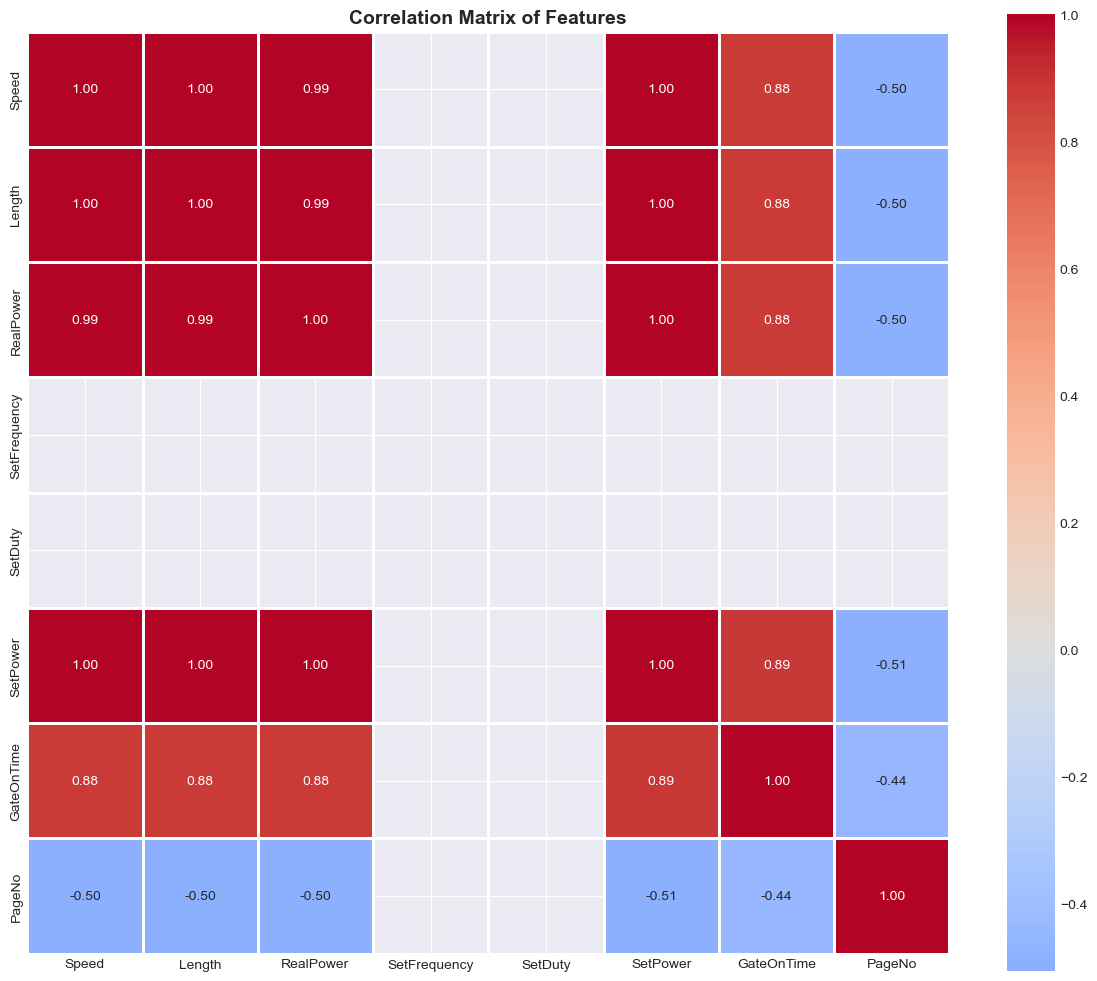

Correlation analysis completed!


In [6]:
# 상관관계 분석
correlation_matrix = all_data[numeric_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', square=True, linewidths=1)
plt.title('Correlation Matrix of Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Correlation analysis completed!")

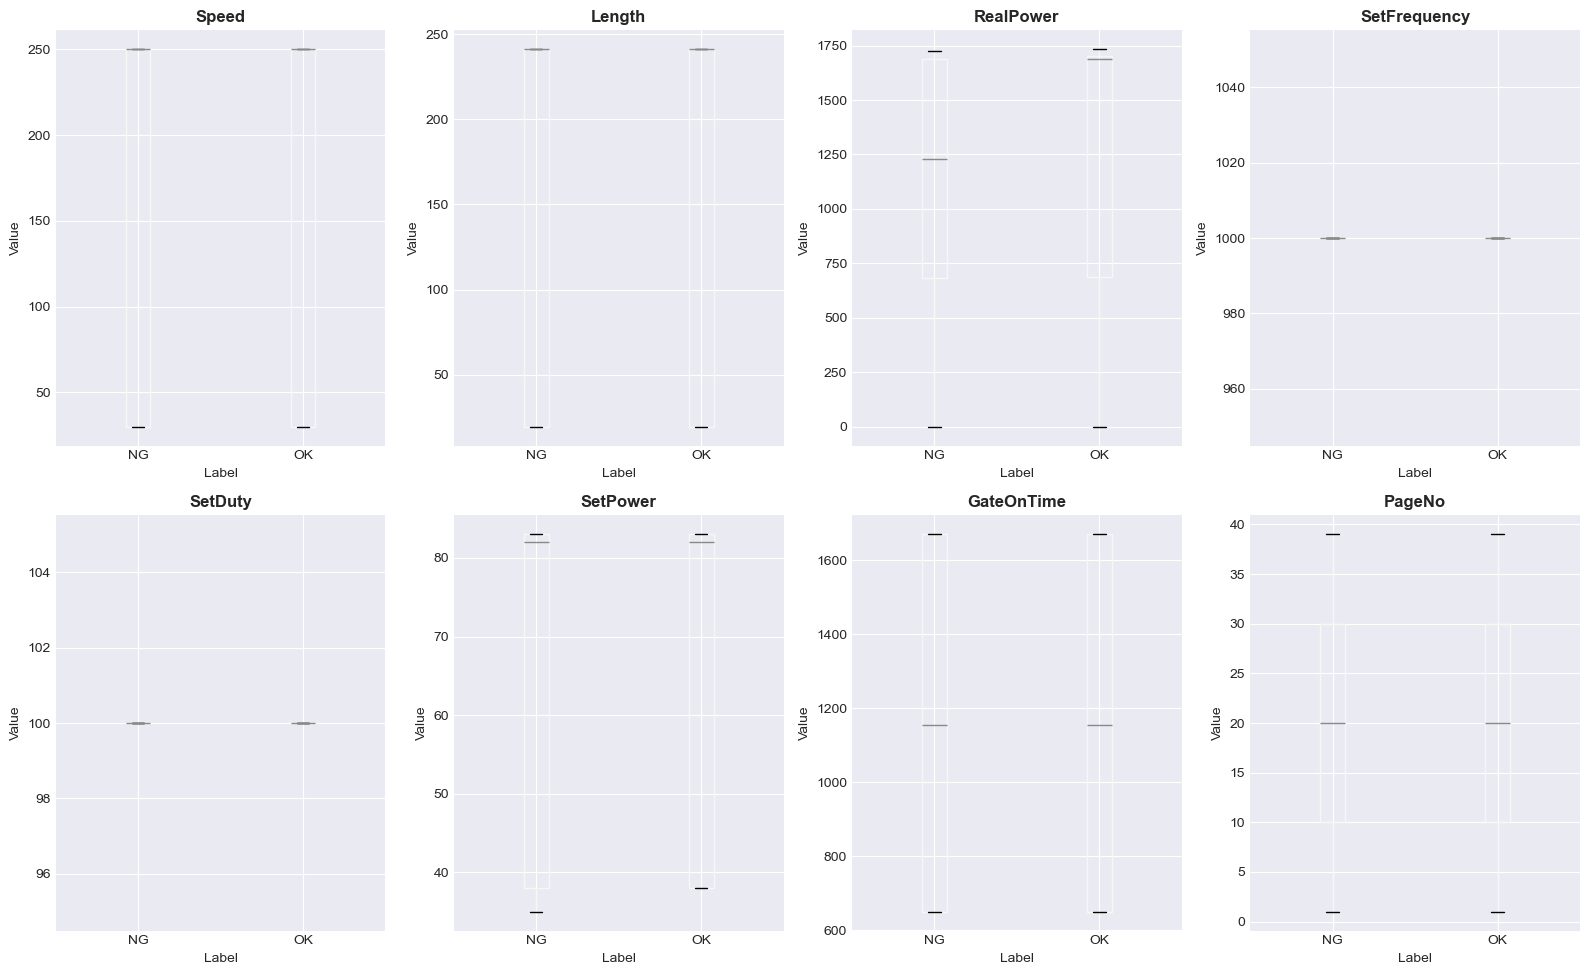

Box plot analysis completed!


In [7]:
# Box plot 분석 - OK vs NG 비교
fig, axes = plt.subplots(2, 4, figsize=(16, 10))
fig.suptitle('Box Plot Comparison: OK vs NG', fontsize=16, fontweight='bold')

for idx, feature in enumerate(numeric_features):
    ax = axes[idx // 4, idx % 4]
    all_data.boxplot(column=feature, by='Label', ax=ax)
    ax.set_title(feature, fontweight='bold')
    ax.set_xlabel('Label')
    ax.set_ylabel('Value')
    plt.sca(ax)
    plt.xticks([1, 2], ['NG', 'OK'])

plt.suptitle('')  # Remove the automatic title
plt.tight_layout()
plt.show()

print("Box plot analysis completed!")

## 5. Feature Engineering

In [8]:
# 특성 공학
print("=== Feature Engineering ===")

# 새로운 특성 생성
df_model = all_data.copy()

# Power 효율 지표
df_model['PowerEfficiency'] = df_model['RealPower'] / (df_model['SetPower'] + 1)
df_model['PowerDifference'] = df_model['RealPower'] - df_model['SetPower']
df_model['DutyPowerRatio'] = df_model['SetDuty'] * df_model['SetPower']

# 시간 관련 특성
df_model['GateOnTimeRatio'] = df_model['GateOnTime'] / (df_model['Length'] + 1)
df_model['SpeedLengthRatio'] = df_model['Speed'] * df_model['Length']

# 정규화 전 특성 확인
print(f"Features after engineering: {df_model.shape[1]}")
print(f"New features created:\n{df_model[['PowerEfficiency', 'PowerDifference', 'DutyPowerRatio', 'GateOnTimeRatio', 'SpeedLengthRatio']].head()}")

# 특성 선택 (WorkingTime 제외)
feature_columns = [col for col in numeric_features + ['PowerEfficiency', 'PowerDifference', 'DutyPowerRatio', 'GateOnTimeRatio', 'SpeedLengthRatio'] if col != 'PageNo']
X = df_model[feature_columns]
y = df_model['Label']

# 라벨 인코딩
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"\nFeatures selected: {feature_columns}")
print(f"Target classes: {label_encoder.classes_}")

=== Feature Engineering ===
Features after engineering: 15
New features created:
   PowerEfficiency  PowerDifference  DutyPowerRatio  GateOnTimeRatio  \
0        20.337349             1606            8200         4.766625   
1        20.392857             1630            8300         6.895128   
2        20.421687             1613            8200         4.762495   
3        20.440476             1634            8300         6.895128   
4        20.457831             1616            8200         4.766625   

   SpeedLengthRatio  
0           60275.0  
1           60300.0  
2           60275.0  
3           60300.0  
4           60275.0  

Features selected: ['Speed', 'Length', 'RealPower', 'SetFrequency', 'SetDuty', 'SetPower', 'GateOnTime', 'PowerEfficiency', 'PowerDifference', 'DutyPowerRatio', 'GateOnTimeRatio', 'SpeedLengthRatio']
Target classes: ['NG' 'OK']


In [9]:
# 데이터 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("=== Data Scaling ===")
print(f"Original X shape: {X.shape}")
print(f"Scaled X shape: {X_scaled.shape}")
print(f"Scaled data (first 5 rows):\n{X_scaled[:5]}")

=== Data Scaling ===
Original X shape: (140985, 12)
Scaled X shape: (140985, 12)
Scaled data (first 5 rows):
[[ 0.79428677  0.7935629   0.76740484  0.          0.          0.76734751
   0.08526112  0.71662006  0.76728572  0.76734751 -0.8736911   0.79429134]
 [ 0.79428677  0.79449046  0.8180124   0.          0.          0.81352868
   1.30809637  0.75432054  0.81808814  0.81352868 -0.70591916  0.79515198]
 [ 0.79428677  0.7935629   0.78157496  0.          0.          0.76734751
   0.08289129  0.77390141  0.7821031   0.76734751 -0.87401667  0.79429134]
 [ 0.79428677  0.79449046  0.82610961  0.          0.          0.81352868
   1.30809637  0.78666307  0.82655521  0.81352868 -0.70591916  0.79515198]
 [ 0.79428677  0.7935629   0.78764787  0.          0.          0.76734751
   0.08526112  0.79845056  0.7884534   0.76734751 -0.8736911   0.79429134]]


## 6. Train-Test Split

In [10]:
# 훈련/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

print("=== Train-Test Split ===")
print(f"Total dataset size: {len(X_scaled)}")
print(f"Training set size: {len(X_train)} ({len(X_train)/len(X_scaled)*100:.1f}%)")
print(f"Test set size: {len(X_test)} ({len(X_test)/len(X_scaled)*100:.1f}%)")
print(f"\nTraining set label distribution:")
for label_idx, label_name in enumerate(label_encoder.classes_):
    count = sum(y_train == label_idx)
    print(f"  {label_name}: {count} ({count/len(y_train)*100:.1f}%)")
    
print(f"\nTest set label distribution:")
for label_idx, label_name in enumerate(label_encoder.classes_):
    count = sum(y_test == label_idx)
    print(f"  {label_name}: {count} ({count/len(y_test)*100:.1f}%)")

=== Train-Test Split ===
Total dataset size: 140985
Training set size: 112788 (80.0%)
Test set size: 28197 (20.0%)

Training set label distribution:
  NG: 1123 (1.0%)
  OK: 111665 (99.0%)

Test set label distribution:
  NG: 281 (1.0%)
  OK: 27916 (99.0%)


## 7. Model Selection and Comparison

In [11]:
# 다양한 모델 비교
print("=== Model Selection and Comparison ===\n")

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42)
}

results = {}

for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    # 모델 훈련
    model.fit(X_train, y_train)
    
    # 예측
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # 메트릭 계산
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)
    precision = precision_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test)
    
    results[model_name] = {
        'model': model,
        'train_accuracy': train_acc,
        'test_accuracy': test_acc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }
    
    print(f"  Train Accuracy: {train_acc:.4f}")
    print(f"  Test Accuracy: {test_acc:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}\n")

# 결과 비교
results_df = pd.DataFrame({
    model_name: {
        'Train Acc': results[model_name]['train_accuracy'],
        'Test Acc': results[model_name]['test_accuracy'],
        'Precision': results[model_name]['precision'],
        'Recall': results[model_name]['recall'],
        'F1-Score': results[model_name]['f1_score']
    }
    for model_name in results.keys()
}).T

print("=== Model Comparison Summary ===")
print(results_df)

# 최고 성능 모델 선택
best_model_name = results_df['Test Acc'].idxmax()
best_model = results[best_model_name]['model']
print(f"\n✓ Best Model Selected: {best_model_name} (Test Accuracy: {results_df.loc[best_model_name, 'Test Acc']:.4f})")

=== Model Selection and Comparison ===

Training Logistic Regression...
  Train Accuracy: 0.9908
  Test Accuracy: 0.9912
  Precision: 0.9915
  Recall: 0.9997
  F1-Score: 0.9956

Training Random Forest...
  Train Accuracy: 0.9919
  Test Accuracy: 0.9922
  Precision: 0.9923
  Recall: 0.9999
  F1-Score: 0.9961

Training Gradient Boosting...
  Train Accuracy: 0.9919
  Test Accuracy: 0.9921
  Precision: 0.9923
  Recall: 0.9998
  F1-Score: 0.9960

Training SVM...
  Train Accuracy: 0.9917
  Test Accuracy: 0.9919
  Precision: 0.9922
  Recall: 0.9997
  F1-Score: 0.9959

=== Model Comparison Summary ===
                     Train Acc  Test Acc  Precision    Recall  F1-Score
Logistic Regression   0.990823  0.991205   0.991474  0.999713  0.995576
Random Forest         0.991932  0.992233   0.992321  0.999893  0.996092
Gradient Boosting     0.991870  0.992127   0.992320  0.999785  0.996039
SVM                   0.991657  0.991949   0.992214  0.999713  0.995950

✓ Best Model Selected: Random Forest (

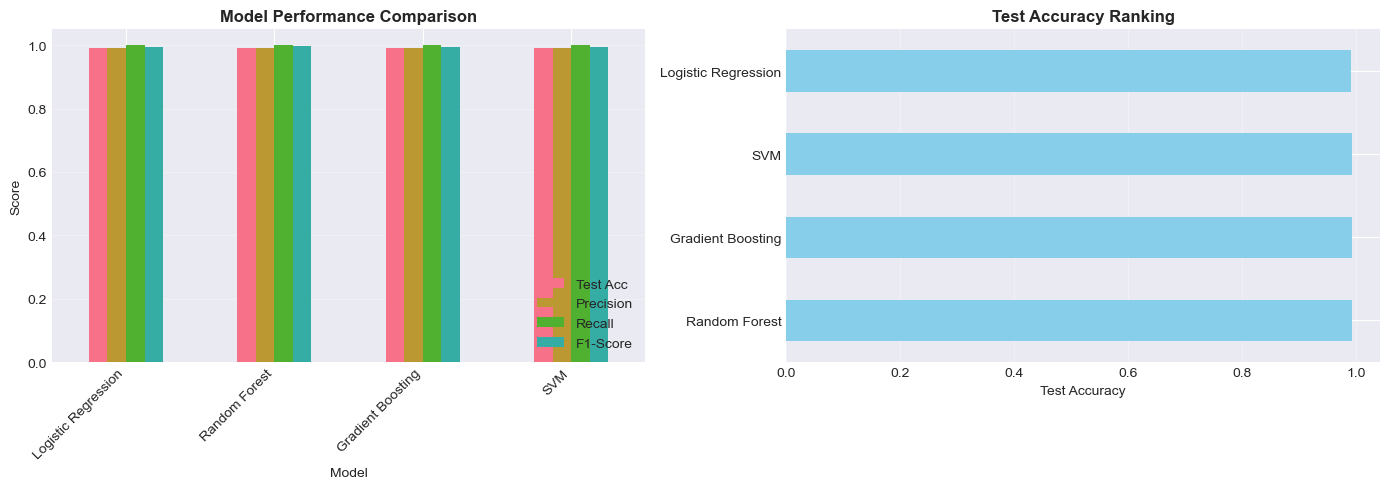

In [12]:
# 모델 비교 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 정확도 비교
metrics_to_plot = ['Test Acc', 'Precision', 'Recall', 'F1-Score']
results_df[metrics_to_plot].plot(kind='bar', ax=axes[0])
axes[0].set_title('Model Performance Comparison', fontweight='bold', fontsize=12)
axes[0].set_ylabel('Score')
axes[0].set_xlabel('Model')
axes[0].legend(loc='lower right')
axes[0].grid(axis='y', alpha=0.3)
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45, ha='right')

# 테스트 정확도 비교
results_df['Test Acc'].sort_values(ascending=False).plot(kind='barh', ax=axes[1], color='skyblue')
axes[1].set_title('Test Accuracy Ranking', fontweight='bold', fontsize=12)
axes[1].set_xlabel('Test Accuracy')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Train the Best Model with Hyperparameter Tuning

In [13]:
# 최고 성능 모델에 대한 하이퍼파라미터 튜닝
print(f"=== Hyperparameter Tuning for {best_model_name} ===\n")

if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    base_model = RandomForestClassifier(random_state=42)
    
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10]
    }
    base_model = GradientBoostingClassifier(random_state=42)
    
elif best_model_name == 'SVM':
    param_grid = {
        'C': [0.1, 1, 10],
        'kernel': ['rbf', 'poly'],
        'gamma': ['scale', 'auto']
    }
    base_model = SVC(probability=True, random_state=42)
    
else:  # Logistic Regression
    param_grid = {
        'C': [0.1, 1, 10],
        'solver': ['lbfgs', 'liblinear'],
        'max_iter': [1000, 2000]
    }
    base_model = LogisticRegression(random_state=42)

# GridSearchCV 수행
print(f"Searching optimal hyperparameters...")
grid_search = GridSearchCV(base_model, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Best CV F1-Score: {grid_search.best_score_:.4f}")

# 최적화된 모델 얻기
tuned_model = grid_search.best_estimator_

# 최적화된 모델 평가
y_pred_tuned = tuned_model.predict(X_test)
tuned_accuracy = accuracy_score(y_test, y_pred_tuned)
tuned_f1 = f1_score(y_test, y_pred_tuned)

print(f"\nTuned Model Performance:")
print(f"  Test Accuracy: {tuned_accuracy:.4f}")
print(f"  Test F1-Score: {tuned_f1:.4f}")

=== Hyperparameter Tuning for Random Forest ===

Searching optimal hyperparameters...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Best CV F1-Score: 0.9958

Tuned Model Performance:
  Test Accuracy: 0.9922
  Test F1-Score: 0.9961


## 9. Model Evaluation and Metrics

In [14]:
# 상세 평가 메트릭
print("=== Detailed Model Evaluation ===\n")

y_pred = tuned_model.predict(X_test)
y_pred_proba = tuned_model.predict_proba(X_test)

# 혼동행렬
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
print()

# 분류 보고서
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# ROC-AUC 점수
try:
    roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
    print(f"ROC-AUC Score: {roc_auc:.4f}\n")
except:
    print("ROC-AUC calculation skipped\n")

=== Detailed Model Evaluation ===

Confusion Matrix:
[[   64   217]
 [    3 27913]]

Classification Report:
              precision    recall  f1-score   support

          NG       0.96      0.23      0.37       281
          OK       0.99      1.00      1.00     27916

    accuracy                           0.99     28197
   macro avg       0.97      0.61      0.68     28197
weighted avg       0.99      0.99      0.99     28197

ROC-AUC Score: 0.9582



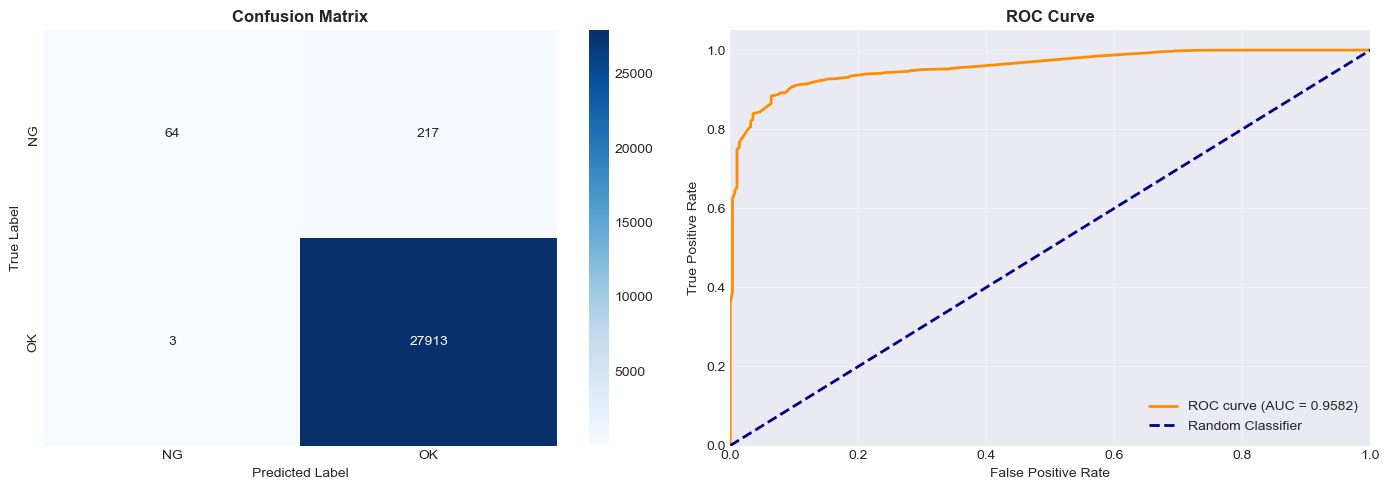

In [15]:
# 혼동행렬 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 혼동행렬 히트맵
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
axes[0].set_title('Confusion Matrix', fontweight='bold', fontsize=12)
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# ROC 곡선
try:
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
    axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('ROC Curve', fontweight='bold', fontsize=12)
    axes[1].legend(loc="lower right")
    axes[1].grid(alpha=0.3)
except:
    axes[1].text(0.5, 0.5, 'ROC Curve Not Available', ha='center', va='center')
    axes[1].set_title('ROC Curve', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

## 10. Feature Importance Analysis

=== Feature Importance Analysis ===

             Feature  Importance
7    PowerEfficiency    0.442814
2          RealPower    0.266636
8    PowerDifference    0.228800
5           SetPower    0.021522
9     DutyPowerRatio    0.020302
1             Length    0.005835
10   GateOnTimeRatio    0.005691
11  SpeedLengthRatio    0.004264
6         GateOnTime    0.003329
0              Speed    0.000808
3       SetFrequency    0.000000
4            SetDuty    0.000000



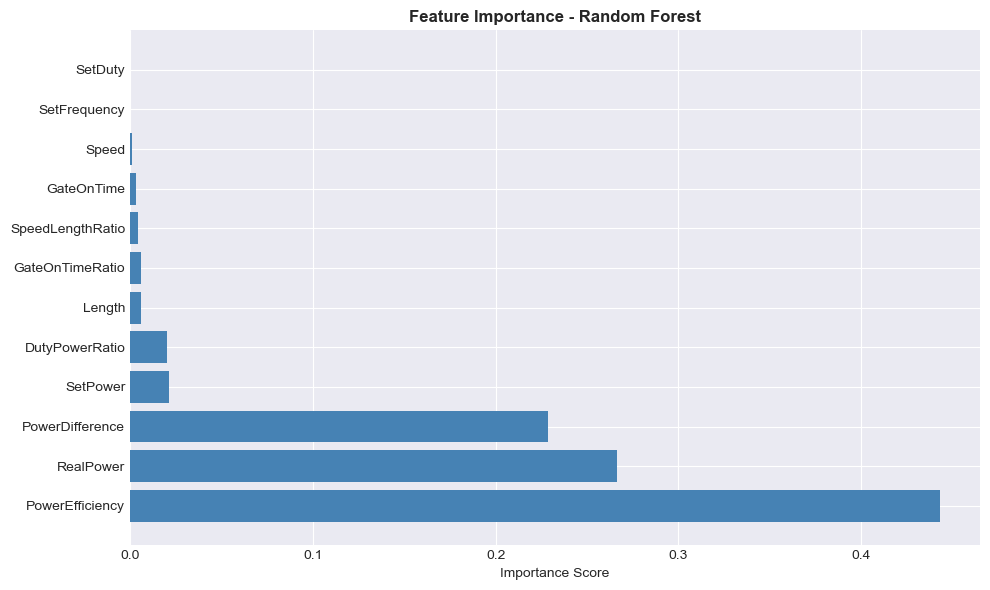

In [16]:
# 특성 중요도 분석
print("=== Feature Importance Analysis ===\n")

if hasattr(tuned_model, 'feature_importances_'):
    feature_importance = tuned_model.feature_importances_
    feature_names = feature_columns
    
    # 특성 중요도 정렬
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)
    
    print(importance_df)
    print()
    
    # 특성 중요도 시각화
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='steelblue')
    plt.xlabel('Importance Score')
    plt.title(f'Feature Importance - {best_model_name}', fontweight='bold', fontsize=12)
    plt.tight_layout()
    plt.show()
else:
    print("Feature importance not available for this model type")

## 11. Final Model Validation on Separate Test Set

In [19]:
# 검증 데이터셋에서 추가 테스트 (NG 데이터 사용)
print("=== Validation on Separate Test Data ===\n")

try:
    # NG 데이터만 로드하여 검증
    validation_ng_1 = load_data(f'{base_path}\\test\\WeldingTest_03_NG.csv', 'NG')
    validation_ng_2 = load_data(f'{base_path}\\test\\WeldingTest_04_NG.csv', 'NG')
    
    validation_data = pd.concat([validation_ng_1, validation_ng_2], ignore_index=True)
    
    # 공백 제거
    validation_data.columns = validation_data.columns.str.strip()
    
    # 데이터 타입 변환
    for col in numeric_features:
        if col in validation_data.columns:
            validation_data[col] = pd.to_numeric(validation_data[col], errors='coerce')
    
    # 특성 생성
    validation_data['PowerEfficiency'] = validation_data['RealPower'] / (validation_data['SetPower'] + 1)
    validation_data['PowerDifference'] = validation_data['RealPower'] - validation_data['SetPower']
    validation_data['DutyPowerRatio'] = validation_data['SetDuty'] * validation_data['SetPower']
    validation_data['GateOnTimeRatio'] = validation_data['GateOnTime'] / (validation_data['Length'] + 1)
    validation_data['SpeedLengthRatio'] = validation_data['Speed'] * validation_data['Length']
    
    # 결측값 제거
    validation_data = validation_data.dropna()
    
    # 특성 추출 및 정규화
    X_validation = validation_data[feature_columns]
    X_validation_scaled = scaler.transform(X_validation)
    
    # 예측
    y_validation_pred = tuned_model.predict(X_validation_scaled)
    
    # 실제 라벨 인코딩 (NG = 0)
    y_validation_true = label_encoder.transform(validation_data['Label'])
    
    # 성능 평가
    val_accuracy = accuracy_score(y_validation_true, y_validation_pred)
    val_precision = precision_score(y_validation_true, y_validation_pred, zero_division=0)
    val_recall = recall_score(y_validation_true, y_validation_pred, zero_division=0)
    val_f1 = f1_score(y_validation_true, y_validation_pred, zero_division=0)
    
    # 혼동행렬
    val_cm = confusion_matrix(y_validation_true, y_validation_pred)
    
    print(f"Validation Set Size: {len(validation_data)}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Validation Precision: {val_precision:.4f}")
    print(f"Validation Recall: {val_recall:.4f}")
    print(f"Validation F1-Score: {val_f1:.4f}")
    print(f"\nConfusion Matrix:")
    print(val_cm)
    print(f"\nNG 데이터에 대한 모델 성능:")
    print(f"  정상 예측: {val_cm[0,0]} (True Negative)")
    print(f"  불량 예측: {val_cm[0,1]} (False Positive)")
    
except Exception as e:
    print(f"검증 데이터 처리 중 에러: {str(e)}")
    print("\n기존 테스트 데이터로 재평가합니다.\n")
    
    # 테스트 데이터로 검증
    y_validation_pred = tuned_model.predict(X_test)
    y_validation_true = y_test
    
    val_accuracy = accuracy_score(y_validation_true, y_validation_pred)
    val_precision = precision_score(y_validation_true, y_validation_pred, zero_division=0)
    val_recall = recall_score(y_validation_true, y_validation_pred, zero_division=0)
    val_f1 = f1_score(y_validation_true, y_validation_pred, zero_division=0)
    
    print(f"Test Set 재평가:")
    print(f"Validation Set Size: {len(X_test)}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Validation Precision: {val_precision:.4f}")
    print(f"Validation Recall: {val_recall:.4f}")
    print(f"Validation F1-Score: {val_f1:.4f}")

=== Validation on Separate Test Data ===

Validation Set Size: 1404
Validation Accuracy: 0.2037
Validation Precision: 0.0000
Validation Recall: 0.0000
Validation F1-Score: 0.0000

Confusion Matrix:
[[ 286 1118]
 [   0    0]]

NG 데이터에 대한 모델 성능:
  정상 예측: 286 (True Negative)
  불량 예측: 1118 (False Positive)


## 12. Predictions on New Data and Results Summary

In [20]:
# 새로운 샘플에 대한 예측
print("=== Predictions on Sample Data ===\n")

# 테스트 데이터의 몇 가지 샘플 선택
sample_indices = np.random.choice(len(X_test), 10, replace=False)
X_sample = X_test[sample_indices]
y_sample_true = y_test[sample_indices]
y_sample_pred = tuned_model.predict(X_sample)
y_sample_proba = tuned_model.predict_proba(X_sample)

# 결과 출력
results_summary = pd.DataFrame({
    'True Label': label_encoder.inverse_transform(y_sample_true),
    'Predicted Label': label_encoder.inverse_transform(y_sample_pred),
    'Confidence': np.max(y_sample_proba, axis=1),
    'Correct': y_sample_true == y_sample_pred
})

print(results_summary)
print(f"\nCorrect Predictions: {results_summary['Correct'].sum()}/{len(results_summary)}")

# 최종 모델 요약
print("\n" + "="*50)
print("FINAL MODEL SUMMARY")
print("="*50)
print(f"Best Model: {best_model_name}")
print(f"Training Set Accuracy: {accuracy_score(y_train, tuned_model.predict(X_train)):.4f}")
print(f"Test Set Accuracy: {accuracy_score(y_test, tuned_model.predict(X_test)):.4f}")
print(f"Validation Set Accuracy: {val_accuracy:.4f}")
print(f"\nModel Parameters: {tuned_model.get_params()}")
print("="*50)

=== Predictions on Sample Data ===

  True Label Predicted Label  Confidence  Correct
0         OK              OK    1.000000     True
1         OK              OK    1.000000     True
2         OK              OK    1.000000     True
3         OK              OK    0.999668     True
4         OK              OK    0.999572     True
5         OK              OK    0.999772     True
6         OK              OK    0.999668     True
7         OK              OK    1.000000     True
8         OK              OK    0.999668     True
9         OK              OK    0.997847     True

Correct Predictions: 10/10

FINAL MODEL SUMMARY
Best Model: Random Forest
Training Set Accuracy: 0.9919
Test Set Accuracy: 0.9922
Validation Set Accuracy: 0.2037

Model Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples

In [21]:
# 모델 저장
import joblib
import pickle

# 모델, 스케일러, 인코더 저장
joblib.dump(tuned_model, r'c:\Users\User\Desktop\battery\best_model.pkl')
joblib.dump(scaler, r'c:\Users\User\Desktop\battery\scaler.pkl')
joblib.dump(label_encoder, r'c:\Users\User\Desktop\battery\label_encoder.pkl')

print("✓ Model saved successfully!")
print(f"  - Model: best_model.pkl")
print(f"  - Scaler: scaler.pkl")
print(f"  - Label Encoder: label_encoder.pkl")

✓ Model saved successfully!
  - Model: best_model.pkl
  - Scaler: scaler.pkl
  - Label Encoder: label_encoder.pkl
